# Classifier Prep

In [1]:
import pandas as pd

## Load Data

In [2]:
url = 'https://s3-us-west-2.amazonaws.com/pcadsassessment/parking_citations.corrupted.csv'
df = pd.read_csv(url)

/home/peterdraznik/miniconda3/envs/1_traffic_citations_modeling_pipeline/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (0,7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df.head(3)

Ticket number           Issue Date  Issue time Meter Id  Marked Time  \
0    1103341116  2015-12-21T00:00:00      1251.0      NaN          NaN   
1    1103700150  2015-12-21T00:00:00      1435.0      NaN          NaN   
2    1104803000  2015-12-21T00:00:00      2055.0      NaN          NaN   

  RP State Plate  Plate Expiry Date  VIN Make Body Style Color  \
0             CA           200304.0  NaN  NaN         PA    GY   
1             CA           201512.0  NaN  NaN         VN    WH   
2             CA           201503.0  NaN  NaN         PA    BK   

          Location  Route  Agency Violation code Violation Description  \
0  13147 WELBY WAY  01521     1.0         4000A1    NO EVIDENCE OF REG   
1    525 S MAIN ST   1C51     1.0         4000A1    NO EVIDENCE OF REG   
2    200 WORLD WAY    2R2     2.0           8939            WHITE CURB   

   Fine amount   Latitude  Longitude  
0         50.0    99999.0    99999.0  
1         50.0    99999.0    99999.0  
2         58.0  6439997.9  1802686.4

In [4]:
df.drop(columns=['Ticket number', 'Location', 'Violation Description', 'Latitude', 'Longitude', 'Route'], inplace=True)

In [5]:
df_with_make = df[~df['Make'].isnull()]
df_without_make = df[df['Make'].isnull()]
df_with_make.dtypes

Issue Date            object
Issue time           float64
Meter Id              object
Marked Time          float64
RP State Plate        object
Plate Expiry Date    float64
VIN                   object
Make                  object
Body Style            object
Color                 object
Agency               float64
Violation code        object
Fine amount          float64
dtype: object

## Setup Popular Makes

In [6]:
s_num_citations_per_make = df_with_make[df_with_make['Make'] != 'OTHR']['Make'].value_counts()
num_popular_makes = 25
popular_makes=s_num_citations_per_make[:num_popular_makes].keys().tolist()
s_num_citations_per_make[:num_popular_makes]

TOYT    721411
HOND    491961
FORD    382695
NISS    311324
CHEV    297076
BMW     199221
MERZ    177307
VOLK    149501
HYUN    133864
DODG    127764
LEXS    124508
KIA     101746
JEEP    100909
AUDI     84229
MAZD     79853
GMC      62391
CHRY     57317
INFI     56809
ACUR     52703
SUBA     46898
VOLV     42330
TOYO     40064
MITS     37842
CADI     34080
MNNI     30885
Name: Make, dtype: int64

In [7]:
df_with_make['is_popular_make'] = df_with_make['Make'].isin(popular_makes)
df_with_make[['Make', 'is_popular_make']].head(7)

df_popular_makes = df_with_make[df_with_make['is_popular_make'] == True]

/home/peterdraznik/miniconda3/envs/1_traffic_citations_modeling_pipeline/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


### Ticket Number 
Notes:
    - Should just drop


### Date/Time columns
Notes:
    - Parse out either hour and minute or day of month, day of year, month, and year

In [8]:
def try_to_convert(val, method, default=None):
    try:
        return method(val)
    except:
        return default
from functools import partial

try_to_convert_to_int = partial(try_to_convert, method=int)
import numpy as np
s = df_with_make['Issue time'] / df_with_make['Issue time'].apply(try_to_convert_to_int)
s.sum()  / len(s)

0.9997636283190715

In [9]:

df_with_make['issue_minute'] = df_with_make['Issue time'].dropna().astype(int).astype(str).str.slice(start=-2).apply(try_to_convert_to_int)
df_with_make['issue_hour'] = df_with_make['Issue time'].dropna().astype(int).astype(str).str.slice(stop=-2).apply(try_to_convert_to_int)

df_with_make['marked_minute'] = df_with_make['Marked Time'].dropna().astype(int).astype(str).str.slice(start=-2).apply(try_to_convert_to_int)
df_with_make['marked_hour'] = df_with_make['Marked Time'].dropna().astype(int).astype(str).str.slice(stop=-2).apply(try_to_convert_to_int)
df_with_make.drop(columns=['Marked Time', 'Issue time'], inplace=True)

/home/peterdraznik/miniconda3/envs/1_traffic_citations_modeling_pipeline/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/peterdraznik/miniconda3/envs/1_traffic_citations_modeling_pipeline/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/peterdraznik/miniconda3/envs/1_traffic_citations_modeling_pipeline/lib/python3.6/site-packages/ipykernel_launcher.p

In [10]:
df_with_make['Issue Date'] = pd.to_datetime(df_with_make['Issue Date'])
df_with_make['Plate Expiry Date'] = pd.to_datetime(df_with_make['Plate Expiry Date'])

/home/peterdraznik/miniconda3/envs/1_traffic_citations_modeling_pipeline/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/peterdraznik/miniconda3/envs/1_traffic_citations_modeling_pipeline/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [11]:
df_with_make['issue_day_of_month'] = df_with_make['Issue Date'].dt.day
df_with_make['issue_day_of_year'] = df_with_make['Issue Date'].dt.dayofyear
df_with_make['issue_month'] = df_with_make['Issue Date'].dt.month
df_with_make['issue_year'] = df_with_make['Issue Date'].dt.year

/home/peterdraznik/miniconda3/envs/1_traffic_citations_modeling_pipeline/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/peterdraznik/miniconda3/envs/1_traffic_citations_modeling_pipeline/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/peterdraznik/miniconda3/envs/1_traffic_citations_modeling_pipeline/lib/python3.6/site-packages/ipykernel_launcher.p

In [12]:
df_with_make['plate_expiry_day_of_month'] = df_with_make['Plate Expiry Date'].dt.day
df_with_make['plate_expiry_day_of_year'] = df_with_make['Plate Expiry Date'].dt.dayofyear
df_with_make['plate_expiry_month'] = df_with_make['Plate Expiry Date'].dt.month
df_with_make['plate_expiry_year'] = df_with_make['Plate Expiry Date'].dt.year

df_with_make.drop(columns=['Issue Date', 'Plate Expiry Date'], inplace=True)

/home/peterdraznik/miniconda3/envs/1_traffic_citations_modeling_pipeline/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/peterdraznik/miniconda3/envs/1_traffic_citations_modeling_pipeline/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/peterdraznik/miniconda3/envs/1_traffic_citations_modeling_pipeline/lib/python3.6/site-packages/ipykernel_launcher.p

### RP State Plate
Notes:
    - One hot encode or too large?

### VIN
Notes:
    - Either parse make from VIN or drop from usage

In [13]:
from utils.vin_validator import VIN
#df_without_make['vin_make'] = df_without_make['VIN'].apply(lambda vin: VIN(vin).manufacturer)
df_with_make['vin_make'] = df_with_make['VIN'].apply(lambda vin: VIN(vin).manufacturer)

df_with_make['is_popular_vin_make'] = df_with_make['vin_make'].isin(popular_makes)
df_with_make.drop(columns=['VIN', 'vin_make'], inplace=True)

/home/peterdraznik/miniconda3/envs/1_traffic_citations_modeling_pipeline/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/peterdraznik/miniconda3/envs/1_traffic_citations_modeling_pipeline/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


### Body Style
Notes:
    - Groupby observed manufacturer makes 

In [14]:
#possible_body_styles_per_popular_make = df_popular_makes.groupby('Make')['Body Style'].unique()
#for make, body_styles in possible_body_styles_per_popular_make.items():
#    df_with_make[f'is_possible_body_style_from_{make}'] = df['Body Style'].isin(body_styles)
#df_with_make.drop(columns=['Body Style'], inplace=True)

### Color
Notes:
    - One hot encode

### Location
Notes:
    - Drop for v1

### Route
Notes:
    - Drop for v1

### Agency
Notes:
    - One Hot Encode

In [16]:
df_with_make['Agency'] = df_with_make['Agency'].dropna().astype(int).astype(str)




/home/peterdraznik/miniconda3/envs/1_traffic_citations_modeling_pipeline/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


### Violation Code
Notes:
    - One Hot Encode

In [17]:
num_records_per_violation_code = df['Violation code'].value_counts().sort_values(ascending=False)
num_violation_codes = num_records_per_violation_code.sum()
a = 100*num_records_per_violation_code / num_violation_codes



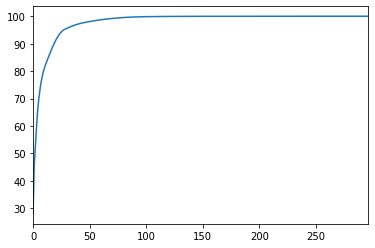

In [18]:
%matplotlib inline
pd.Series(a.cumsum().values).plot()

In [19]:
df_with_make.dtypes

Meter Id                      object
RP State Plate                object
Make                          object
Body Style                    object
Color                         object
Agency                        object
Violation code                object
Fine amount                  float64
is_popular_make                 bool
issue_minute                 float64
issue_hour                   float64
marked_minute                float64
marked_hour                  float64
issue_day_of_month             int64
issue_day_of_year              int64
issue_month                    int64
issue_year                     int64
plate_expiry_day_of_month    float64
plate_expiry_day_of_year     float64
plate_expiry_month           float64
plate_expiry_year            float64
is_popular_vin_make             bool
dtype: object

In [20]:
num_records_per_make_per_violation_code = df_with_make.groupby(['Make', 'Violation code',]).apply(len)
num_records_per_make = df_with_make.groupby('Make').apply(len)
pct_violation_code_per_makes_violations = num_records_per_make_per_violation_code / num_records_per_make

In [21]:
popular_violation_codes = num_records_per_violation_code[:22].keys().tolist()
df_with_make['violation_code'] = df_with_make['Violation code'].apply(lambda val: val if val in popular_violation_codes else 'OTHR')
df_with_make.drop(columns=['Violation code'], inplace=True)



/home/peterdraznik/miniconda3/envs/1_traffic_citations_modeling_pipeline/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/peterdraznik/miniconda3/envs/1_traffic_citations_modeling_pipeline/lib/python3.6/site-packages/pandas/core/frame.py:4097: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [22]:
df_with_make['violation_code'].value_counts()

80.69BS     1220241
88.13B+      761734
OTHR         345319
80.56E4+     303235
80.58L       299488
5204A-       267438
80.69B       185573
80.69C       145099
5200         119369
80.56E1       94060
80.69AP+      78415
80.61         61250
22500E        54241
80.69A+       48427
80.70         46740
80.56E2       45450
8069BS        44610
80.69AA+      44402
4000A1        43006
22500F        39872
22502A        38239
80.73.2       37157
22514         34179
Name: violation_code, dtype: int64

In [23]:
pct_violation_code_per_makes_violations.unstack().T.loc[popular_violation_codes, popular_makes]


Make                TOYT      HOND      FORD      NISS      CHEV       BMW  \
Violation code                                                               
80.69BS         0.324342  0.314576  0.289429  0.296052  0.282116  0.234117   
88.13B+         0.183556  0.158541  0.146150  0.156609  0.144700  0.232872   
80.56E4+        0.061069  0.056742  0.072379  0.072882  0.076533  0.042912   
80.58L          0.077721  0.072654  0.058428  0.068135  0.055289  0.079214   
5204A-          0.060638  0.062761  0.067981  0.056057  0.063559  0.066213   
80.69B          0.046778  0.044333  0.043136  0.045775  0.043413  0.037100   
80.69C          0.037535  0.036979  0.034615  0.035266  0.036671  0.028807   
5200            0.012722  0.017853  0.021829  0.016234  0.022876  0.082863   
80.56E1         0.024496  0.022435  0.019608  0.022738  0.019665  0.021604   
80.69AP+        0.019930  0.018680  0.019099  0.020239  0.019662  0.012850   
80.61           0.014667  0.014099  0.017351  0.015273  0.019816  0.010611   
22500E          0.015958  0.016164  0.012339  0.015852  0.012818  0.007871   
80.69A+         0.012011  0.011174  0.011032  0.011808  0.010708  0.007484   
80.70           0.012028  0.011147  0.010389  0.012029  0.010916  0.010250   
8069BS               NaN  0.012247  0.009888  0.010565  0.010095  0.007770   
80.56E2         0.011198  0.009054  0.010763  0.010513  0.012441  0.010466   
80.69AA+        0.011051  0.010167  0.010920  0.011670  0.011105  0.007208   
4000A1          0.000003  0.009281  0.012545  0.009402  0.014097  0.008940   
22500F          0.009497  0.008789  0.010497  0.009495  0.012616  0.007976   
22502A          0.008501  0.006618  0.010839  0.009257  0.010250  0.007735   
80.73.2         0.006067  0.007415  0.013637  0.007208  0.012620  0.005281   
22514           0.008536  0.008545  0.009062  0.009858  0.009822  0.005476   

Make                MERZ      VOLK      HYUN      DODG  ...       GMC  \
Violation code                                          ...             
80.69BS         0.230442  0.312359  0.301515  0.278913  ...  0.240403   
88.13B+         0.245038  0.193905  0.192120  0.140063  ...  0.128047   
80.56E4+        0.053495  0.041016  0.059060  0.079185  ...  0.144348   
80.58L          0.076489  0.086541  0.086267  0.056737  ...  0.040166   
5204A-          0.062863  0.075344  0.047518  0.065472  ...  0.058903   
80.69B          0.038397  0.038047  0.042722  0.046155  ...  0.041304   
80.69C          0.028211  0.034762  0.034318  0.030932  ...  0.032425   
5200            0.068125  0.023692  0.016539  0.028647  ...  0.015948   
80.56E1         0.025453  0.019986  0.023031  0.019129  ...  0.019025   
80.69AP+        0.014985  0.013605  0.016606  0.019653  ...  0.018961   
80.61           0.011178  0.009579  0.011131  0.018542  ...  0.020307   
22500E          0.008454  0.011926  0.013432  0.011623  ...  0.010402   
80.69A+         0.008669  0.008609  0.009592  0.011506  ...  0.014842   
80.70           0.011742  0.008970  0.011265  0.012061  ...  0.009473   
8069BS          0.002233  0.012100  0.011123  0.009987  ...  0.007277   
80.56E2         0.012380  0.008187  0.008621  0.010911  ...  0.014457   
80.69AA+        0.007935  0.007799  0.009540  0.010512  ...  0.012229   
4000A1          0.005894  0.009184  0.005692  0.014574  ...  0.011588   
22500F          0.008595  0.007057  0.007508  0.011670  ...  0.013544   
22502A          0.008939  0.007291  0.010832  0.010778  ...  0.010594   
80.73.2         0.007084  0.007164  0.003347  0.014691  ...  0.013431   
22514           0.005223  0.006094  0.008367  0.009596  ...  0.009569   

Make                CHRY      INFI      ACUR      SUBA      VOLV      TOYO  \
Violation code                                                               
80.69BS         0.294625  0.261701  0.294955  0.335899  0.298913       NaN   
88.13B+         0.157859  0.191554  0.183785  0.209263  0.188897       NaN   
80.56E4+        0.068636  0.060167  0.048612  0.032581  0.0388

## Start Setting up the Pipeline

In [24]:
categorical_features = ['violation_code', 'RP State Plate', 'Agency', 'Meter Id', 'Color', 'Body Style']
category_to_int_maps = {
    col: { 
            key: index 
            for index, key in enumerate(df_with_make[col].value_counts().keys())
        }
    for col in categorical_features
}

for col in categorical_features:
    category_to_int_map = { 
        key: index 
        for index, key in enumerate(df_with_make[col].value_counts().keys())
    }
    df_with_make[col] = df_with_make[col].apply(category_to_int_map.get)

/home/peterdraznik/miniconda3/envs/1_traffic_citations_modeling_pipeline/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


In [25]:
numeric_features = ['Fine amount', 'issue_minute', 'issue_hour', 'marked_minute', 'marked_hour', 'issue_day_of_month', 'issue_day_of_year','issue_month', 'issue_year', 'plate_expiry_day_of_year', 'plate_expiry_day_of_month', 'plate_expiry_month', 'plate_expiry_year']#' 


{'80.69BS': 0,
 '88.13B+': 1,
 'OTHR': 2,
 '80.56E4+': 3,
 '80.58L': 4,
 '5204A-': 5,
 '80.69B': 6,
 '80.69C': 7,
 '5200': 8,
 '80.56E1': 9,
 '80.69AP+': 10,
 '80.61': 11,
 '22500E': 12,
 '80.69A+': 13,
 '80.70': 14,
 '80.56E2': 15,
 '8069BS': 16,
 '80.69AA+': 17,
 '4000A1': 18,
 '22500F': 19,
 '22502A': 20,
 '80.73.2': 21,
 '22514': 22}

In [26]:
df_with_make.drop(columns=['Make'], inplace=True, errors='ignore') 

In [40]:
import json
with open('../models/info.json', 'w') as outfile:
    json.dump(dict(popular_makes=popular_makes, popular_violation_codes=popular_violation_codes, numeric_features=numeric_features, category_to_int_maps=category_to_int_maps, should_add_label=True), outfile)


X = df_with_make[[col for col in df_with_make.columns if col not in  ['Make', 'is_popular_make']]]
Y = df_with_make['is_popular_make']


In [28]:
X[(X == 'OTHR').any(axis=1)]


/home/peterdraznik/miniconda3/envs/1_traffic_citations_modeling_pipeline/lib/python3.6/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


Empty DataFrame
Columns: [Meter Id, RP State Plate, Body Style, Color, Agency, Fine amount, issue_minute, issue_hour, marked_minute, marked_hour, issue_day_of_month, issue_day_of_year, issue_month, issue_year, plate_expiry_day_of_month, plate_expiry_day_of_year, plate_expiry_month, plate_expiry_year, is_popular_vin_make, violation_code]
Index: []

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import balanced_accuracy_score, make_scorer
from sklearn.impute import SimpleImputer
from sklearn.naive_bayes import GaussianNB
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler,FunctionTransformer
from sklearn.pipeline import Pipeline
from matplotlib import pyplot as plt
from sklearn.externals import joblib

/home/peterdraznik/miniconda3/envs/1_traffic_citations_modeling_pipeline/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [30]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=-1)),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    #remainder='passthrough'
)

 # define the pipeline object.
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.3, random_state=30)

In [31]:
categorical_features
numeric_features


['Fine amount',
 'issue_minute',
 'issue_hour',
 'marked_minute',
 'marked_hour',
 'issue_day_of_month',
 'issue_day_of_year',
 'issue_month',
 'issue_year',
 'plate_expiry_day_of_year',
 'plate_expiry_day_of_month',
 'plate_expiry_month',
 'plate_expiry_year']

In [32]:
classifiers = {
    'NB': {
        'class': GaussianNB,
        'params': {}
    },
    'SVM': {
        'class': SVC,
        'params': {}
    }
}


In [33]:
pipeline_steps_base = [
    ('preprocessor', preprocessor), 
    ('pca', TruncatedSVD()),
]
pipelines = {
    classifier_name: Pipeline(pipeline_steps_base + [(classifier_name, classifier_info['class']())])
    for classifier_name, classifier_info in classifiers.items()
}
parameters_base = {
    'pca__n_components':[5, 15, 45],#,10,20,50
}

parameters = {
    classifier_name: {
        **parameters_base,
        **classifier_info.get('params', {})
    }
    for classifier_name, classifier_info in classifiers.items()
}

grids = {
    classifier_name: GridSearchCV(pipelines[classifier_name], param_grid=parameters.get(classifier_name, parameters_base), scoring=make_scorer(balanced_accuracy_score), cv=2)
    for classifier_name in pipelines.keys()
}
get_model_path = lambda model_name: f'../models/{model_name}.joblib'
def print_grid_results(grid):
    print(f"score: {grid.score(X_test, y_test)}")
    print(f"Best Params: {grid.best_params_}")
    y_pred = grid.predict(X_test)
    conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
    print(f"Pct True in predictions: {len(y_pred[y_pred==True] )/ len(y_pred)}")
    labels = ['Not Popular', 'Popular']
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(conf_mat / len(y_pred), cmap=plt.cm.Blues)
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('Expected')
    plt.show()
    print(conf_mat / len(y_pred))

---------------------------------------------------------------------------------------- 
 NB
score: 0.6230187194144065
Best Params: {'pca__n_components': 45}
Pct True in predictions: 0.8427777403799079
[[0.03597896 0.05871194]
 [0.1212433  0.7840658 ]]


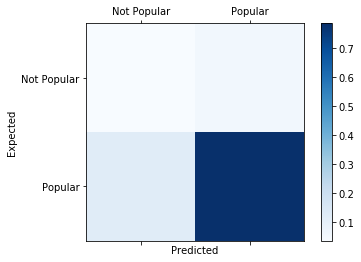

In [34]:
for classifier_name, grid in list(grids.items())[:1]:
    print("-"*88, "\n", classifier_name)
    grid.fit(X_train, y_train)
    joblib.dump(grid, get_model_path(classifier_name))
    print_grid_results(grid)
    

In [35]:
joblib.dump(grid, get_model_path(classifier_name))

['../models/NB.joblib']

In [36]:
model_name = 'NB'
model = joblib.load(get_model_path(model_name))


In [37]:
len(df_with_make[df_with_make['is_popular_make'] == True]) / len(df_with_make)

0.9052548866976443

In [43]:
get_model_path = lambda model_name: f'../models/{model_name}.joblib'
joblib.dump(grid, get_model_path('current'))


['../models/current.joblib']

In [41]:
grid


GridSearchCV(cv=2, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('imputer',
                                                                                          SimpleImputer(add_indicator=False,
                                                                                                        copy=True,
                    

In [44]:


model = joblib.load('../models/NB.joblib')

In [45]:
model

GridSearchCV(cv=2, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('imputer',
                                                                                          SimpleImputer(add_indicator=False,
                                                                                                        copy=True,
                    

In [48]:
'{"Issue Date":"2015-12-21T00:00:00","Issue time":1251.0,"Meter Id":null,"Marked Time":null,"RP State Plate":"CA","Plate Expiry Date":200304.0,"VIN":null,"Make":null,"Body Style":"PA","Color":"GY","Agency":1.0,"Violation code":"4000A1","Fine amount":50.0}'



df_without_make.iloc[0].to_json()

'{"Issue Date":"2015-12-21T00:00:00","Issue time":1251.0,"Meter Id":null,"Marked Time":null,"RP State Plate":"CA","Plate Expiry Date":200304.0,"VIN":null,"Make":null,"Body Style":"PA","Color":"GY","Agency":1.0,"Violation code":"4000A1","Fine amount":50.0}'